# PHYS591000 Lab 10
--- 
## Goal
In this Lab 10, you will practice:

* Generative model -- Generative-Adversarial Networks (GANs)




## Introduction

* We will build a Generative-Adversarial Network(GAN) which is trained on di-jet events generated using MadGraph5, Pythia8, and Delphes3 fast detector simulation.  
* We demonstrate that a number of kinematic distributions can be reproduced by the GAN which is trained by di-jet 4 momentums with a very good level of agreement.

* The GAN architecture comes from [DijetGAN Paper: arXiv:1903.0243](https://arxiv.org/pdf/1903.02433.pdf)   
* The original code comes from [Github Repository - hmyin516](https://github.com/hmyin516/AnomalyDetection/blob/main/DijetGAN/DijetGAN.ipynb)   

## Data Description

* It consists of 1M QCD dijet events and 100k W'->XY events, with X->qq and Y->qq. The W', X, and Y masses are 3.5 TeV, 500 GeV and 100 GeV respectively. The events are produced using Pythia8 and Delphes 3.4.1, with no pileup or MPI included. They are selected using a single fat-jet (R=1) trigger with pT threshold of 1.2 TeV. Furthermore, each dataset contains several low-level features and high-level feartures. (e.g. pxj1', 'pyj1', 'pzj1', 'mj1', 'tau1j1', 'tau2j1', 'tau3j1', 'pxj2', 'pyj2', 'pzj2', 'mj2', 'tau1j2', 'tau2j2', 'tau3j2

Ref. [Data Information](https://zenodo.org/record/3832254#.YIZSqi2cbOT) 


# Workflow

* Load data: "events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5" (Hint: [Pandas Read h5](https://pandas.pydata.org/docs/reference/api/pandas.read_hdf.html))    
* Select training data with specific training features and normalize them between -1 and 1
* Split data into training data and test data (test_size = 0.25) and load data in batch (Hint: [tf.data.Dataset.from_tensor_slices](https://www.tensorflow.org/api_docs/python/tf/data/Dataset))    
* Create Architectures (generator and discriminator)  
    * the dimension of noise is 128
    * `Generator`   
    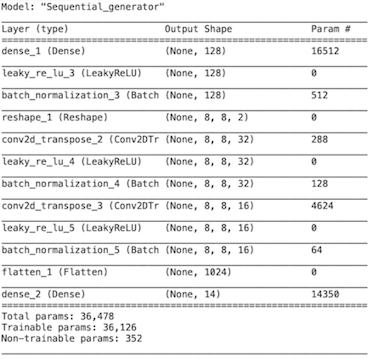
    
    * `Discriminator`  
    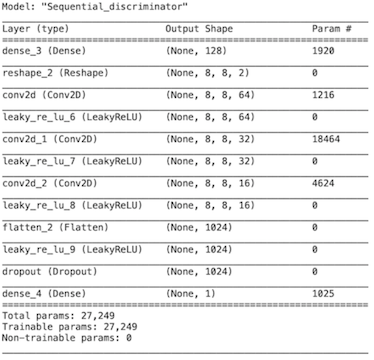
    
* Define the loss and optimizers   
    * generator loss `mse`   
    * discriminator loss `BinaryCrossentropy(from_logits=True)`  
    * The discriminator and the generator optimizers are different since you will train two networks separately.   
          please use Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2) where LEARNING_RATE = 1e-5, BETA_1 = 0.5, BETA_2 = 0.9
    * You can read [Tensorflow GAN Example](https://www.tensorflow.org/tutorials/generative/dcgan) to figure it out.  
    
* Define the training loop
     * You can read [The training loop](https://www.tensorflow.org/tutorials/generative/dcgan#define_the_training_loop)
* Training and save generator loss and discriminator loss
    * we will use four-momentum(px,py, pz, m) of dijets in the training
* After training, please save generator model (Hint: [Save and Load a Model](https://www.tensorflow.org/guide/keras/save_and_serialize#how_to_save_and_load_a_model))
* Using generator to generate two di-jet four-momentums and please use these two four-momentums to calculate $m_{J_1}$, $m_{J_2}$, $m_{JJ}$ and $E_{JJ}$, and then compare to features from our real two di-jet four-momentums



## Useful Reference

Ref. [DijetGAN Paper: arXiv:1903.0243](https://arxiv.org/pdf/1903.02433.pdf)    
Ref. [Sildes-3rd Machine Learning Workshop](https://indico.cern.ch/event/766872/contributions/3357985/attachments/1831274/2999056/3rd_IML_Serena_Palazzo.pdf)    
Ref. [Sildes-Conditional DijetGAN for Anomaly Detection](https://docs.google.com/presentation/d/1YHI9CO__0F7zVz-53KO6ndTfe2IO-EJ8_jobR7YXsCI/edit#slide=id.gc7b29cb834_0_20)       
Ref. [The original code](https://github.com/hmyin516/AnomalyDetection/blob/main/DijetGAN/DijetGAN.ipynb)    
Ref. [Official Datasets for LHC Olympics 2020 Anomaly Detection Challenge](https://lhco2020.github.io/homepage/)  
Ref. [Data Source](https://zenodo.org/record/3832254#.YIZSqi2cbOT)    
Ref. [Tensorflow GAN Example](https://www.tensorflow.org/tutorials/generative/dcgan)   
Ref. [Jet Substructure](https://arxiv.org/pdf/1409.6298.pdf)   
Ref: [Pandas Read h5](https://pandas.pydata.org/docs/reference/api/pandas.read_hdf.html)     
Ref: [tf.data.Dataset.from_tensor_slices](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)     
Ref: [Tensorflow GAN Example](https://www.tensorflow.org/tutorials/generative/dcgan)    
Ref: [The training loop](https://www.tensorflow.org/tutorials/generative/dcgan#define_the_training_loop)




In [1]:
#!/usr/bin/env python
# encoding: utf-8
from __future__ import absolute_import, division, print_function, unicode_literals
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import gc
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential, load_model


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

print("Using Tensorflow {}".format(tf.__version__))
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("{} GPUs found".format(len(physical_devices)))

/kaggle/input/phys591000-week10/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5
/kaggle/input/phys591000-week10/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5
/kaggle/input/phys591000-week10/requirements.txt
/kaggle/input/phys591000-week10/FinalData_ppzee.hdf5
/kaggle/input/phys591000-week10/requirements-core.txt
/kaggle/input/phys591000-week10/events_anomalydetection_DelphesHerwig_qcd_features.h5
/kaggle/input/phys591000-week10/FinalData_ppttbar.hdf5
/kaggle/input/phys591000-week10/Pretrain_Model/discriminator.h5
/kaggle/input/phys591000-week10/Pretrain_Model/generator.h5
/kaggle/input/phys591000-week10/Pretrain_Model/LOSS.npz
Using Tensorflow 2.4.1
1 GPUs found


# Part 1 - Load Data and Data Preprocessing

* Load data: `/kaggle/input/phys591000-week10/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5` (Hint: [Pandas Read h5](https://pandas.pydata.org/docs/reference/api/pandas.read_hdf.html))    
* Select training data with specific training features and normalize them between -1 and 1  (Hint: [sklearn: MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)) 
* Split data into training data and test data (test_size = 0.25) and batch the data
(Hint:[train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), Hint: [tf.data.Dataset.from_tensor_slices](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)) 

### 1.1 - Code
* Load the dataset from Load data: `/kaggle/input/phys591000-week10/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5` 
* Show feastures inside this data.
* Please make figures for those festures.

Hint: [Pandas Read h5](https://pandas.pydata.org/docs/reference/api/pandas.read_hdf.html)

shape of data:  (99999, 14)
          pxj1         pyj1         pzj1         mj1      tau1j1     tau2j1  \
0 -1698.670044  -884.039978   723.843018  105.035004   83.721703  46.282101   
1  1246.660034 -1133.010010  -921.987000  159.865997  133.781998  58.968601   
2   420.975006 -1739.790039   281.553986   93.665901   77.925797  10.605900   
3   161.048996 -1664.859985 -2005.099976  116.327003   61.819698  38.143600   
4  -564.754028 -1315.599976 -1087.410034  513.015991  276.446991  50.629799   

      tau3j1         pxj2         pyj2         pzj2         mj2      tau1j2  \
0  13.635700  1539.439941   372.238007  -295.865997  461.574005  431.343994   
1  30.377399 -1218.489990  1108.380005   182.147003  514.883972  462.654999   
2   6.916520  -510.779999  1484.069946   227.175995  475.316986  217.113998   
3  18.414400  -188.942993  1556.900024  -561.664001  561.236023  348.181000   
4  35.460999   326.164001  1050.239990  1201.000000  108.752998   89.666603   

       tau2j2     tau3

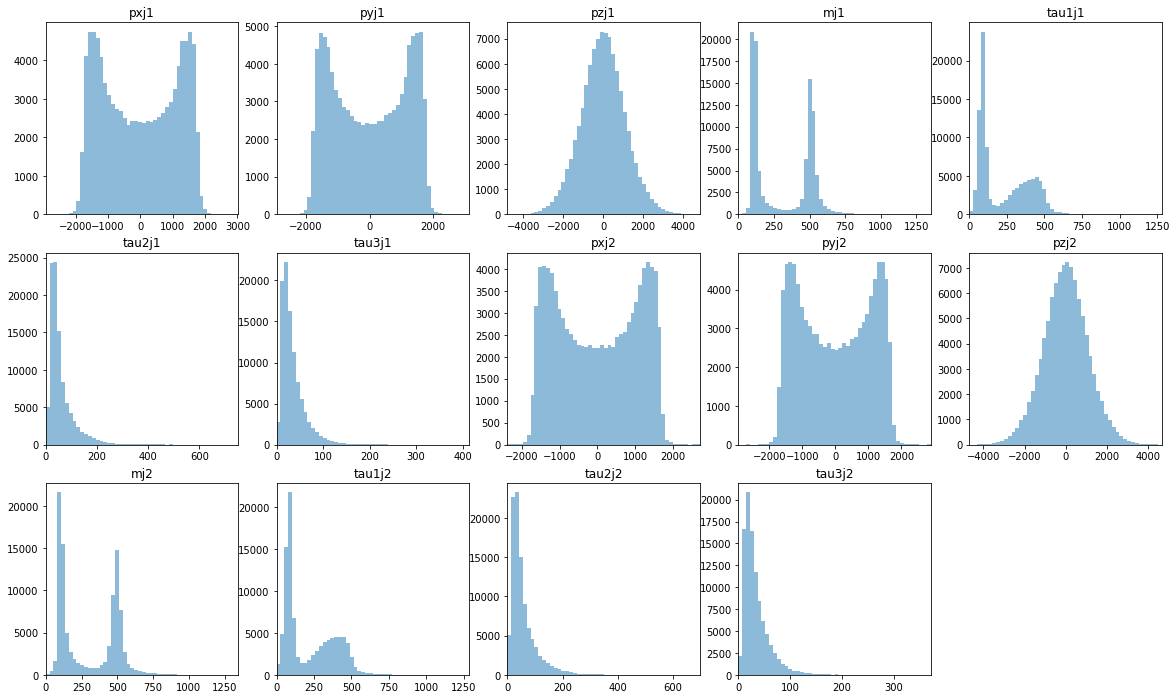

In [2]:
##############################################################################
#Code for 1.1
# 1. Load the dataset from Load data: `/kaggle/input/phys591000-week10/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5` 
# 2. Show features inside this data.
# 3. Please make figures for those festures.
##############################################################################
# Please code in this cell

"""
Load File 
"""
data = pd.read_hdf('/kaggle/input/phys591000-week10/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5')
print('shape of data: ', data.shape)
print(data.head())

"""
Show features
"""
features = data.columns
print('\nfeatures = ', features)

"""
Figures for Features
"""
plt.figure(figsize=(20,12))
for ifs,feature in enumerate(features):
    plt.subplot(3,5,ifs+1)
    x = data[feature]
    plt.hist(x, alpha=0.5, bins=50)
    plt.xlim(min(x),max(x))
    plt.title(feature)
plt.show()

##############################################################################

### 1.2 - Code
* Select training data with specific training features and normalize them between -1 and 1
* training features = ['pxj1', 'pyj1', 'pzj1', 'mj1', 'pxj2', 'pyj2', 'pzj2', 'mj2']
* Please show the shape of your data after you select training features.

Hint: [sklearn: MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

(99999, 8)
           pxj1      pyj1      pzj1       mj1      pxj2      pyj2      pzj2  \
0     -0.586251 -0.326059  0.143290 -0.844642  0.537551  0.136255 -0.060302   
1      0.403153 -0.408361 -0.197365 -0.763542 -0.543159  0.389022  0.041978   
2      0.125786 -0.608946  0.051745 -0.861458 -0.265839  0.518021  0.051613   
3      0.038471 -0.584176 -0.421549 -0.827940 -0.139725  0.543028 -0.117174   
4     -0.205342 -0.468720 -0.231604 -0.241196  0.062122  0.369058  0.259980   
...         ...       ...       ...       ...       ...       ...       ...   
99994 -0.085051 -0.605472  0.067492 -0.857762  0.020051  0.597276 -0.042053   
99995  0.343694  0.184317  0.038746 -0.813361 -0.440367 -0.093645 -0.468657   
99996 -0.447834 -0.062302 -0.289323 -0.828840  0.383274  0.055411  0.263356   
99997 -0.065792  0.555082 -0.018679 -0.248549 -0.032486 -0.464912 -0.314839   
99998  0.516708 -0.275520 -0.047172 -0.829995 -0.659379  0.277382  0.109711   

            mj2  
0     -0.312863  
1   

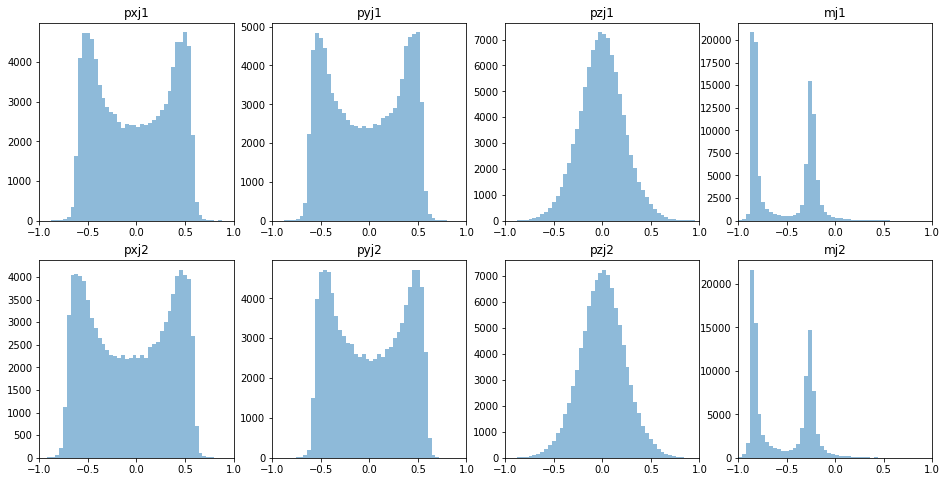

CPU times: user 1.85 s, sys: 9.69 ms, total: 1.86 s
Wall time: 1.86 s


In [3]:
%%time
##############################################################################
#Code for 1.2
# 1. Select training data with specific training features and normalize them between -1 and 1
# 2. training features = ['pxj1', 'pyj1', 'pzj1', 'mj1', 'pxj2', 'pyj2', 'pzj2', 'mj2']
# 3. Please show the shape of your data after you select training features.
##############################################################################
# Please code in this cell


"""
Define Features
"""
train_features = ['pxj1', 'pyj1', 'pzj1', 'mj1', 'pxj2', 'pyj2', 'pzj2', 'mj2']

"""
Normalize all inputs between -1 and 1
"""
scaler = MinMaxScaler(feature_range=(-1,1))
scaled_data = scaler.fit_transform(data[train_features])
print(scaled_data.shape)

train_data = pd.DataFrame()
for ifs,feature in enumerate(train_features):
    train_data[feature] = scaled_data[:,ifs]

print(train_data)

"""
Figures for Features
"""
plt.figure(figsize=(16,8))
for ifs,feature in enumerate(train_features):
    plt.subplot(2,4,ifs+1)
    x = train_data[feature]
    plt.hist(x, alpha=0.5, bins=50)
    plt.xlim(min(x),max(x))
    plt.title(feature)
plt.show()


##############################################################################

### 1.3 - Code
* Split data into training data and test data (test_size = 0.25)
* Please show shape of training data and test data after splitting
* Batch the training data and test data with batch size=512 by `tf.data.Dataset.from_tensor_slices`.
* Please show length of training data and test data after batching the training data and test data

Hint:[train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)    
Hint: [tf.data.Dataset.from_tensor_slices](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) 

In [4]:
%%time
##############################################################################
#Code for 1.3
# 1. Split data into training data and test data (test_size = 0.25)
# 2. Please show shape of training data and test data after splitting
# 3. Batch the training data and test data with batch size=512 by `tf.data.Dataset.from_tensor_slices`.
# 4. Please show length of training data and test data after batching the training data and test data
##############################################################################
# Please code in this cell
"""
Split data into training data and test data (test_size = 0.25)
"""
X_train, X_test = train_test_split( train_data, test_size=0.25, random_state=42)
print('shape of training_data: ', train_data.shape)
print('shape of X_train: ', X_train.shape)
print('shape of X_test : ', X_test.shape)

BATCH_SIZE = 512
train_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_train)).batch(BATCH_SIZE)
test_dataset  = tf.data.Dataset.from_tensor_slices(np.array(X_test)).batch(BATCH_SIZE)
len_dataset = len(train_dataset)
len_testset = len(test_dataset)

print('\nlength of train_dataset : ', len_dataset)
print('length of test_dataset  : ', len_testset)
print('\nlen(X_train)/BATCH_SIZE = ', len(X_train)/BATCH_SIZE)
print('len(X_test) /BATCH_SIZE = ', len(X_test)/BATCH_SIZE)
##############################################################################

shape of training_data:  (99999, 8)
shape of X_train:  (74999, 8)
shape of X_test :  (25000, 8)

length of train_dataset :  147
length of test_dataset  :  49

len(X_train)/BATCH_SIZE =  146.482421875
len(X_test) /BATCH_SIZE =  48.828125
CPU times: user 453 ms, sys: 328 ms, total: 781 ms
Wall time: 1.72 s


# Part 2 - Define Architectures, Loss Functions, Optimizers and the Training Loop

* Create Architectures (generator and discriminator)  
    * the dimension of noise is 128
    * `Generator`   
    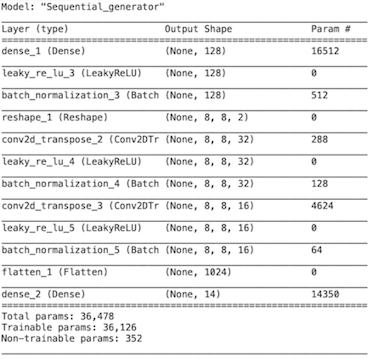
    
    * `Discriminator`  
    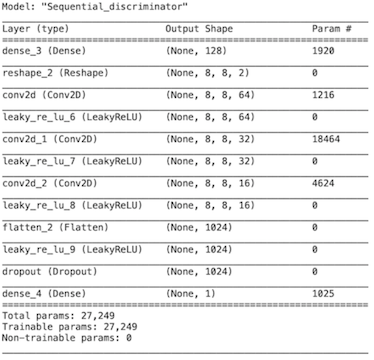
    
* Define the loss and optimizers   
    * generator loss `mse`   
    * discriminator loss `BinaryCrossentropy(from_logits=True)`  
    * The discriminator and the generator optimizers are different since you will train two networks separately.   
          please use Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2) where LEARNING_RATE = 1e-5, BETA_1 = 0.5, BETA_2 = 0.9
    * You can read [Tensorflow GAN Example: Loss](https://www.tensorflow.org/tutorials/generative/dcgan#discriminator_loss) to figure it out.   
    
* Define the training loop
     * You can read [The training loop](https://www.tensorflow.org/tutorials/generative/dcgan#define_the_training_loop)

### 2.1 - Code
* the dimension of noise is 128
* Define generator model 
    * The architecture should be
        * Sequential ->
        * an Input layer with the shape (128,) ->
        * one Dense layer (128, kernel_initializer = 'glorot_uniform') ->
        * LeakyReLU layer (alpha = 0.2) ->
        * BatchNormalization layer ->
        * Reshape layer((8, 8, 2)) ->
        * Conv2DTranspose layer(32, kernel_size = 2, strides = 1, padding = "same") ->
        * LeakyReLU layer (alpha = 0.2) ->
        * BatchNormalization layer ->
        * Conv2DTranspose layer(16, kernel_size = 2, strides = 1, padding = "same") ->
        * LeakyReLU layer (alpha = 0.2) ->
        * BatchNormalization layer ->
        * Flatten ->
        * Output Dense layer with 8 neurons and the activation is tanh
        
* Define discriminator model 
    * The architecture should be
        * Sequential ->
        * an Input layer with the shape (8,) ->
        * one Dense layer with 128 neurons ->
        * Reshape layer((8, 8, 2)) ->
        * Conv2D layer(64, kernel_size = 3, strides = 1, padding = "same") ->
        * LeakyReLU layer (alpha = 0.2) ->
        * Conv2D layer(32, kernel_size = 3, strides = 1, padding = "same") ->
        * LeakyReLU layer (alpha = 0.2) ->
        * Conv2D layer(16, kernel_size = 3, strides = 1, padding = "same") ->
        * LeakyReLU layer (alpha = 0.2) ->
        * Flatten ->
        * LeakyReLU layer (alpha = 0.2) ->
        * Dropout layer with dropout rate 0.2 ->
        * Output Dense layer with 1 neurons and the activation is sigmoid

* Please print the summary of your generator model and discriminator model 

    * the dimension of noise is 128
    * `Generator`   
    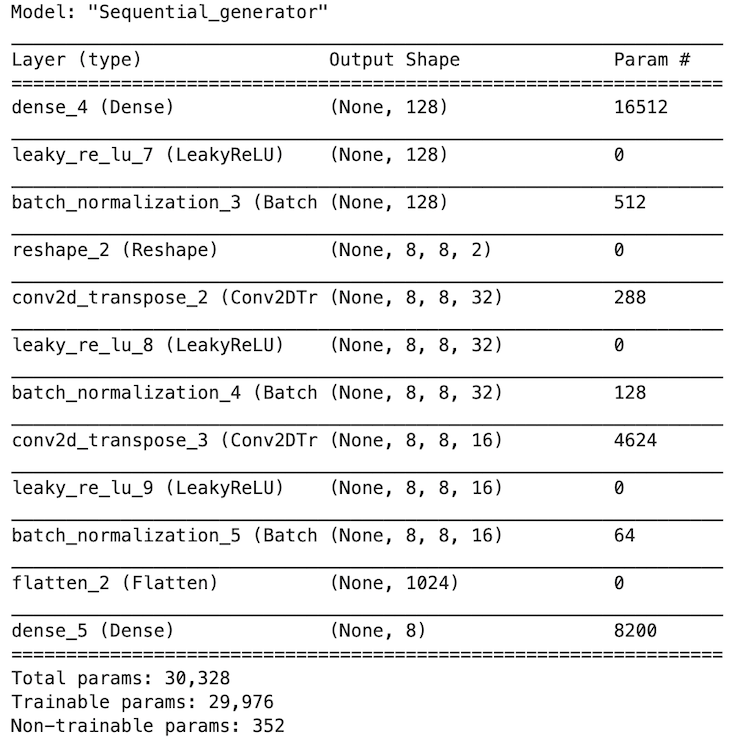    

    * `Discriminator`     
    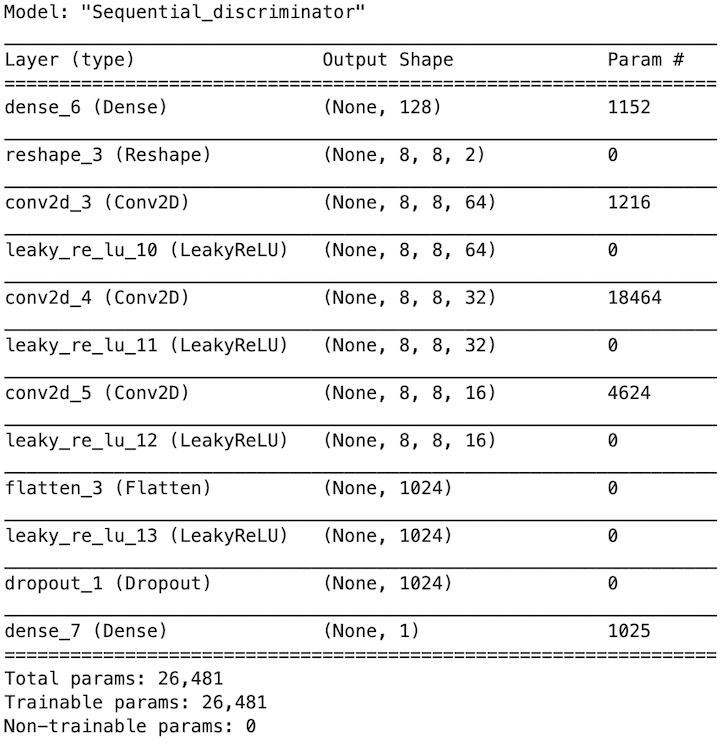

In [5]:
%%time
##############################################################################
#Code for 2.1
# 1. the dimension of noise is 128
""" # 2. 
* The architecture should be
        * Sequential ->
        * an Input layer with the shape (128,) ->
        * one Dense layer (128, kernel_initializer = 'glorot_uniform') ->
        * LeakyReLU layer (alpha = 0.2) ->
        * BatchNormalization layer ->
        * Reshape layer((8, 8, 2)) ->
        * Conv2DTranspose layer(32, kernel_size = 2, strides = 1, padding = "same") ->
        * LeakyReLU layer (alpha = 0.2) ->
        * BatchNormalization layer ->
        * Conv2DTranspose layer(16, kernel_size = 2, strides = 1, padding = "same") ->
        * LeakyReLU layer (alpha = 0.2) ->
        * BatchNormalization layer ->
        * Flatten ->
        * Output Dense layer with 8 neurons and the activation is tanh
        
* Define discriminator model 
    * The architecture should be
        * Sequential ->
        * an Input layer with the shape (8,) ->
        * one Dense layer with 128 neurons ->
        * Reshape layer((8, 8, 2)) ->
        * Conv2D layer(64, kernel_size = 3, strides = 1, padding = "same") ->
        * LeakyReLU layer (alpha = 0.2) ->
        * Conv2D layer(32, kernel_size = 3, strides = 1, padding = "same") ->
        * LeakyReLU layer (alpha = 0.2) ->
        * Conv2D layer(16, kernel_size = 3, strides = 1, padding = "same") ->
        * LeakyReLU layer (alpha = 0.2) ->
        * Flatten ->
        * LeakyReLU layer (alpha = 0.2) ->
        * Dropout layer with dropout rate 0.2 ->
        * Output Dense layer with 1 neurons and the activation is sigmoid
"""
# 3. Please print the summary of your generator model and discriminator model 
##############################################################################
# Please code in this cell

"""
Generator Model
"""
def make_generator_model():
    model = tf.keras.Sequential(name="generator")

    model.add(tf.keras.Input(shape = (128,)))
    model.add(layers.Dense(128, kernel_initializer = 'glorot_uniform'))
    model.add(layers.LeakyReLU(alpha = 0.2))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Reshape((8, 8, 2)))

    model.add(layers.Conv2DTranspose(32, kernel_size = 2, strides = 1, padding = "same"))
    model.add(layers.LeakyReLU(alpha = 0.2))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2DTranspose(16, kernel_size = 3, strides = 1, padding = "same"))
    model.add(layers.LeakyReLU(alpha = 0.2))
    model.add(layers.BatchNormalization())

    model.add(layers.Flatten())
    model.add(layers.Dense(len(train_features), activation = 'tanh'))

    return model

generator = make_generator_model()
generator.summary()


"""
Discriminator Model
"""
def make_discriminator_model():
    model = tf.keras.Sequential(name='discriminator')

    model.add(tf.keras.Input(shape = (len(train_features),)))
    model.add(layers.Dense(128))    
    model.add(layers.Reshape((8, 8, 2)))

    model.add(layers.Conv2D(64, kernel_size = 3, strides = 1, padding = "same"))
    model.add(layers.LeakyReLU(alpha = 0.2))

    model.add(layers.Conv2D(32, kernel_size = 3, strides = 1, padding = "same"))
    model.add(layers.LeakyReLU(alpha = 0.2))

    model.add(layers.Conv2D(16, kernel_size = 3, strides = 1, padding = "same"))
    model.add(layers.LeakyReLU(alpha = 0.2))

    model.add(layers.Flatten())
    model.add(layers.LeakyReLU(alpha = 0.2))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation = 'sigmoid'))

    return model

discriminator = make_discriminator_model()
discriminator.summary()

##############################################################################

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 2)           0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 32)          288       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 32)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 32)          12

### 2.2 - Code
* Define two loss functions  
    * generator loss `mse`   
    * discriminator loss `BinaryCrossentropy(from_logits=True)`  
* Define two optimizers
    * The discriminator and the generator optimizers are different since you will train two networks separately.   
    * please use Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2) where LEARNING_RATE = 1e-5, BETA_1 = 0.5, BETA_2 = 0.9

Hint: [Tensorflow GAN Example: Loss](https://www.tensorflow.org/tutorials/generative/dcgan#discriminator_loss)   
Hint: [Keras: Loss](https://keras.io/api/losses/)   
Hint: [Keras: Optimizers](https://keras.io/api/optimizers/)   

In [6]:
%%time
##############################################################################
#Code for 2.2
# 1. Define two loss functions  
#### generator loss `mse`   
#### discriminator loss `BinaryCrossentropy(from_logits=True)`  
# 2. Define two optimizers
#### The discriminator and the generator optimizers are different since you will train two networks separately.   
#### please use Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2) 
#### where LEARNING_RATE = 1e-5, BETA_1 = 0.5, BETA_2 = 0.9
##############################################################################
# Please code in this cell

mse = tf.keras.losses.MeanSquaredError()
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

"""
Generator loss
"""
@tf.autograph.experimental.do_not_convert
def generator_loss(fake_output):
    return mse(tf.ones_like(fake_output), fake_output)

"""
Discriminator loss
"""
@tf.autograph.experimental.do_not_convert
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

"""
The discriminator and the generator optimizers are different since you will train two networks separately.
"""
LEARNING_RATE = 1e-5; BETA_1 = 0.5; BETA_2 = 0.9
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2)

##############################################################################

CPU times: user 298 µs, sys: 0 ns, total: 298 µs
Wall time: 304 µs


### 2.3 - Code 
* The dimension of noise is 128
* Define the training function and evalution function
    * the training function 
        * please return generator_loss and discriminator_loss
    * the evalution function
        * in the evalution function, we only want to get loss, so you just define a function to get loss in a epoch
        * please return generator_loss and discriminator_loss

* Define the training loop 
    * this training should contiain the training function and the evalution function
    * You shoulde return generator loss and discriminator loss for training data and test data

Hint: [The training loop](https://www.tensorflow.org/tutorials/generative/dcgan#define_the_training_loop)   
Hint: [Github Repository - hmyin516 (evalution function)](https://github.com/hmyin516/AnomalyDetection/blob/1814d94034b3610882febf00667948ab933a454f/DijetGAN/DijetGAN.py#L254)  
Hint: [NumPy Compatibility](https://www.tensorflow.org/tutorials/customization/basics#numpy_compatibility)

In [7]:
%%time
##############################################################################
#Code for 2.3
# 1. The dimension of noise is 128
# 2. Define the training function and evalution function
#### the training function 
######## please return generator_loss and discriminator_loss
#### the evalution function
######## in the evalution function, we only want to get loss, so you just define a function to get loss in a epoch
######## please return generator_loss and discriminator_loss

# 3. Define the training loop 
#### this training should contiain the training function and the evalution function
#### You shoulde return generator loss and discriminator loss for training data and test data
##############################################################################
# Please code in this cell


#Convert tensor to float for loss function plotting
def K_eval(x):
    try:
        return K.get_value(K.to_dense(x))
    except:
        eval_fn = K.function([], [x])
        return eval_fn([])[0]

"""
Train Function
"""
@tf.autograph.experimental.do_not_convert
def train_step_generator():
    gen_input = tf.random.uniform([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_vector = generator(gen_input, training=True)
        fake_output = discriminator(generated_vector, training=True)
        gen_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  
    return gen_loss

@tf.autograph.experimental.do_not_convert
def evaluate_generator():
    gen_input = tf.random.uniform([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_vector = generator(gen_input, training=False)
        fake_output = discriminator(generated_vector, training=False)
        gen_loss = generator_loss(fake_output)
  
    return gen_loss

"""
Evalution Function
"""
@tf.autograph.experimental.do_not_convert
def train_step_discriminator(vectors):
    gen_input = tf.random.uniform([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_vector = generator(gen_input, training=True)

        real_output = discriminator(vectors, training=True)
        fake_output = discriminator(generated_vector, training=True)

        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  
    return disc_loss

@tf.autograph.experimental.do_not_convert
def evaluate_discriminator(vectors):
    gen_input = tf.random.uniform([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_vector = generator(gen_input, training=False)

        real_output = discriminator(vectors, training=False)
        fake_output = discriminator(generated_vector, training=False)

        disc_loss = discriminator_loss(real_output, fake_output)
  
    return disc_loss


"""
Training Loop
"""
def train(dataset, testset, epochs):
    for epoch in tqdm(range(epochs)):
        
        train_gen_loss = 0
        train_disc_loss = 0

        test_gen_loss = 0
        test_disc_loss = 0

        # Training

        for batchnum, image_batch in enumerate(dataset):
            train_disc_loss += K_eval(train_step_discriminator(image_batch)) / len_dataset
            train_gen_loss += K_eval(train_step_generator()) / len_dataset

        train_gen_losses.append(train_gen_loss)
        train_disc_losses.append(train_disc_loss)

        # Evaluation

        for batchnum, test_batch in enumerate(testset):
            test_gen_loss += K_eval(evaluate_generator()) / len_testset
            test_disc_loss += K_eval(evaluate_discriminator(test_batch)) / len_testset
            
        test_gen_losses.append(test_gen_loss)
        test_disc_losses.append(test_disc_loss)

##############################################################################

CPU times: user 36 µs, sys: 0 ns, total: 36 µs
Wall time: 39.3 µs


# Part 3 - Training and Using Generator to generate features
* Training and save generator loss and discriminator loss
    * we will use four-momentum(px,py, pz, m) of dijets in the training
* After training, please save generator model
* Using generator to generate two di-jet four-momentums and please use these two four-momentums calculate $m_{J_1}$, $m_{J_2}$, $m_{JJ}$ and $E_{JJ}$, and then compare to features from our real two di-jet four-momentums

Hint: [Save and Load a Model](https://www.tensorflow.org/guide/keras/save_and_serialize#how_to_save_and_load_a_model)   
Hint: [Units, Quantities, Kinematics, Measurements](https://indico.cern.ch/event/294651/contributions/671927/attachments/552039/760667/Delmastro_ESIPAP2014_1.pdf)

### 3.1 - Code 
* Training and save generator loss and discriminator loss
    * we will use four-momentum(px,py, pz, m) of dijets in the training
* Please train this GAN with `10` epochs
* Please make a figure for Generator Loss 
    * It should contain training and test results
* Please make a figure for Discriminator Loss 
    * It should contain training and test results
          

Hint: [Train the Model](https://www.tensorflow.org/tutorials/generative/dcgan#train_the_model)

In [8]:
%%time
##############################################################################
#Code for 3.1
# 1. Training and save generator loss and discriminator loss
#### we will use four-momentum(px,py, pz, m) of dijets in the training
# 2. Please train this GAN with `10` epochs
# 3. Please make a figure for Generator Loss 
###### It should contain training and test results
# 4. Please make a figure for Discriminator Loss 
###### It should contain training and test results
##############################################################################
# Please code in this cell
train_gen_losses = []
train_disc_losses = []
test_gen_losses = []
test_disc_losses = []

EPOCHS = 10
NOISE_DIM = 128
train(train_dataset, test_dataset, EPOCHS)

##############################################################################

100%|██████████| 10/10 [01:34<00:00,  9.40s/it]

CPU times: user 1min 30s, sys: 1.51 s, total: 1min 32s
Wall time: 1min 34s


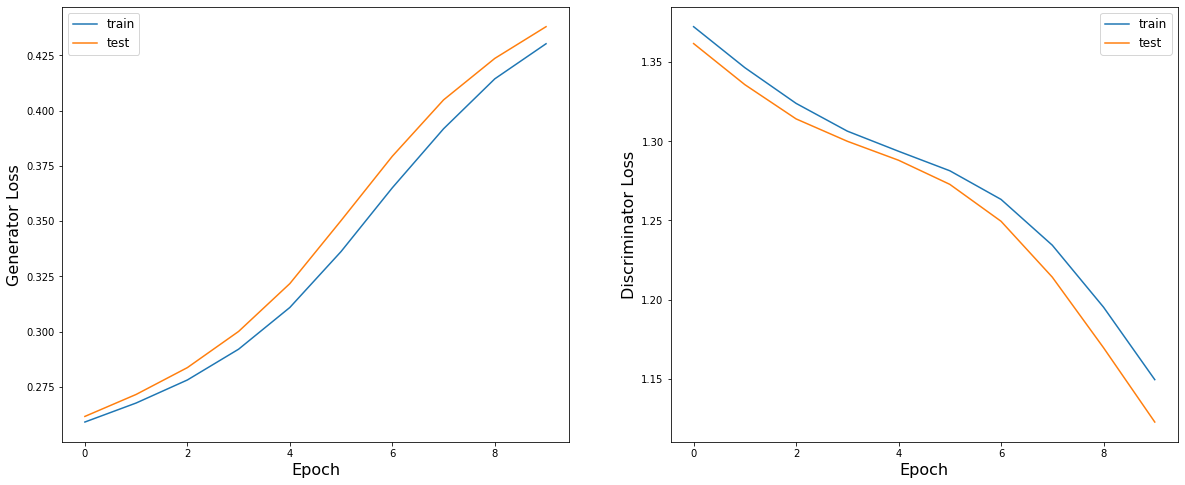

In [9]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(train_gen_losses, label='train')
plt.plot(test_gen_losses, label='test')
plt.legend(fontsize=12)
plt.xlabel('Epoch',fontsize=16)
plt.ylabel('Generator Loss',fontsize=16)

plt.subplot(1,2,2)
plt.plot(train_disc_losses, label='train')
plt.plot(test_disc_losses, label='test')
plt.legend(fontsize=12)
plt.xlabel('Epoch',fontsize=16)
plt.ylabel('Discriminator Loss',fontsize=16)
plt.show()

### 3.2 - Code 
* After training, please save the generator model 

Hint: [Save and Load a Model](https://www.tensorflow.org/guide/keras/save_and_serialize#how_to_save_and_load_a_model)

In [10]:
%%time
##############################################################################
#Code for 3.2
# 1. After training, please save generator model 
##############################################################################
# Please code in this cell
generator.save("generator_GAN.h5")
discriminator.save("discriminator_GAN.h5")
##############################################################################

CPU times: user 35.2 ms, sys: 3.04 ms, total: 38.3 ms
Wall time: 40.4 ms


### 3.3 - Code 
* Using generator to generate two di-jet four-momentums(px, py, pz, m) and please use these two four-momentums to calculate $m_{J_1}$, $m_{J_2}$, $m_{JJ}$ and $E_{JJ}$, and then compare to features from our real two di-jet four-momentums
    * $m_{J_1}$: invariant mass of leading jet
    * $m_{J_2}$: invariant mass of sub-leading jet
    * $m_{JJ}$:  invariant mass of di-jet
    * $E_{JJ}$:  energy of di-jet



Hint: [Units, Quantities, Kinematics, Measurements](https://indico.cern.ch/event/294651/contributions/671927/attachments/552039/760667/Delmastro_ESIPAP2014_1.pdf)

In [11]:
%%time
##############################################################################
#Code for 3.3
# 1.  Using generator to generate two di-jet four-momentums(px, py, pz, m) and please use 
## these two four-momentums calculate $m_{J_1}$, $m_{J_2}$, $m_{JJ}$ and $E_{JJ}$, 
## and then compare to features from our real two di-jet four-momentums
#### $m_{J_1}$: invariant mass of leading jet
#### $m_{J_2}$: invariant mass of sub-leading jet
#### $m_{JJ}$:  invariant mass of di-jet
#### $E_{JJ}$:  energy of di-jet
##############################################################################
# Please code in this cell
generator = load_model('generator_GAN.h5')

NOISE_DIM = 128
BATCH_SIZE = 9999
gen_input = tf.random.uniform([BATCH_SIZE, NOISE_DIM])
generated_vector = generator(gen_input, training=False)
generated_vector = np.array(generated_vector)
generated_vector = scaler.inverse_transform(generated_vector)

df = pd.DataFrame()
for ifs,feature in enumerate(train_features):
    df[feature] = generated_vector[:,ifs]
    
pxj1 = df['pxj1']; pxj2 = df['pxj2']
pyj1 = df['pyj1']; pyj2 = df['pxj2']
pzj1 = df['pzj1']; pzj2 = df['pxj2']
mj1  = df['mj1'] ; mj2  = df['pxj2']

# let c=1, E^2 = m^2*c^4 + p^2*c^2 = m^2 + p^2
Ej1 = np.sqrt(mj1**2 + pxj1**2 + pyj1**2 + pzj1**2)
Ej2 = np.sqrt(mj2**2 + pxj2**2 + pyj2**2 + pzj2**2)

Ejj = Ej1 + Ej2
mjj = np.sqrt(Ejj**2 - ((pxj1+pxj2)**2 + (pyj1+pyj2)**2 + (pzj1+pzj2)**2))
df['mjj'] = mjj
df['Ejj'] = Ejj
##############################################################################

CPU times: user 203 ms, sys: 4.02 ms, total: 207 ms
Wall time: 207 ms


In [12]:
# prepare train data with mjj, Ejj
train_data = pd.read_hdf('/kaggle/input/phys591000-week10/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5')

pxj1_train = train_data['pxj1']; pxj2_train = train_data['pxj2']
pyj1_train = train_data['pyj1']; pyj2_train = train_data['pxj2']
pzj1_train = train_data['pzj1']; pzj2_train = train_data['pxj2']
mj1_train  = train_data['mj1'] ; mj2_train  = train_data['pxj2']

# let c=1, E^2 = m^2*c^4 + p^2*c^2 = m^2 + p^2
Ej1_train = np.sqrt(mj1_train**2 + pxj1_train**2 + pyj1_train**2 + pzj1_train**2)
Ej2_train = np.sqrt(mj2_train**2 + pxj2_train**2 + pyj2_train**2 + pzj2_train**2)

Ejj_train = Ej1_train + Ej2_train
mjj_train = np.sqrt(Ejj_train**2 - ((pxj1_train+pxj2_train)**2 + (pyj1_train+pyj2_train)**2 + (pzj1_train+pzj2_train)**2))
train_data['mjj'] = mjj_train
train_data['Ejj'] = Ejj_train

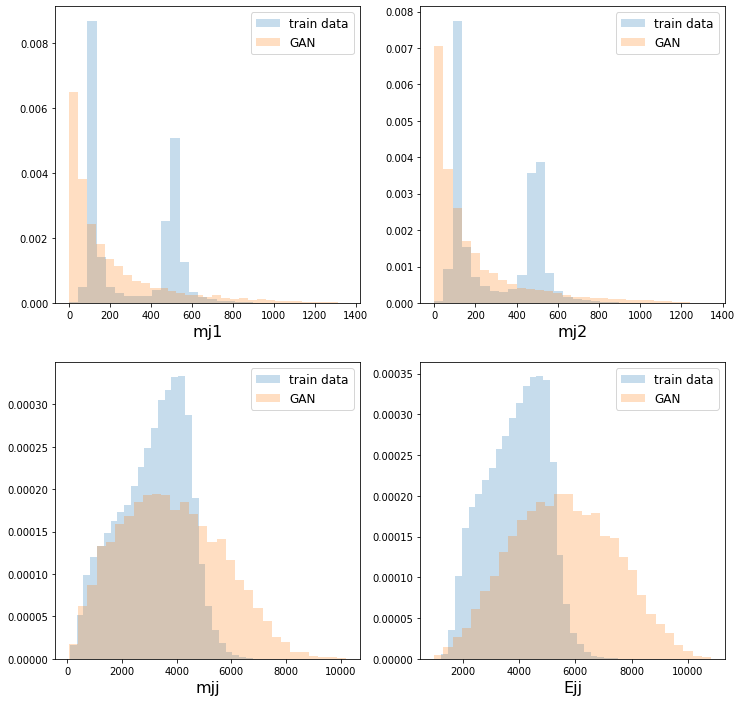

In [13]:
names = ['mj1', 'mj2', 'mjj', 'Ejj']
plt.figure(figsize=(12,12))
for iname, name in enumerate(names):
    plt.subplot(2,2,iname+1)
    x_train = train_data[name]; x = df[name]
    plt.hist(x_train, density=True, bins=30, alpha=0.25, label='train data')
    plt.hist(x, density=True, bins=30, alpha=0.25, label='GAN')
    plt.xlabel(name, fontsize=16)
    plt.legend(fontsize=12)
plt.show()

# Part 4 - Compare 10-Epoch Result to 1000-Epoch Result 
* We have pretrained model with 1000 epochs and put it in a folder `/kaggle/input/phys591000-week10/Pretrain_Model/`. 
* Please load `LOSS.npz` in the folder `Pretrain_model` 
    * Please use `train_gen_loss` and `test_gen_loss` to make a figure for generator loss
    * Please use `train_dic_loss` and `test_dic_loss` to make a figure for discriminator loss
* Please load `generator.h5` in the folder `Pretrain_model` to generate two di-jet four-momentums(px, py, pz, m) and please use these two four-momentums to calculate $m_{J_1}$, $m_{J_2}$, $m_{JJ}$ and $E_{JJ}$, and then compare to features from our real two di-jet four-momentums
    
    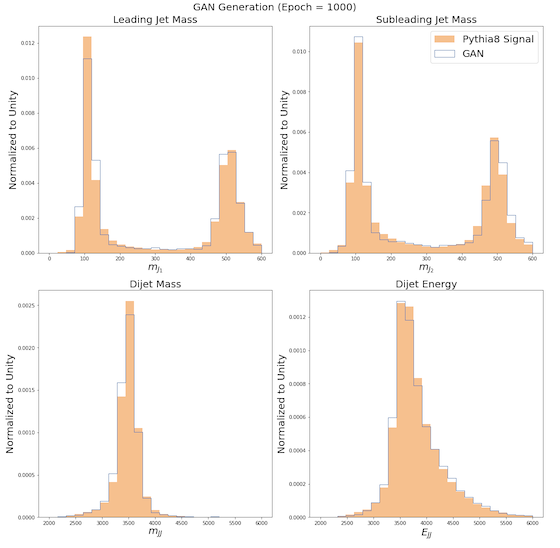

['train_gen_loss', 'train_disc_loss', 'test_gen_loss', 'test_disc_loss']


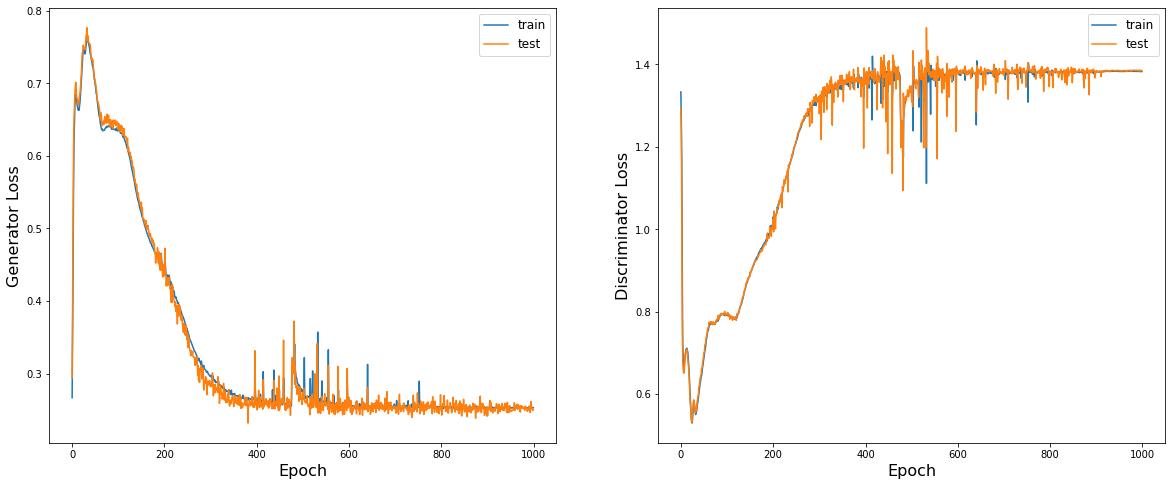

CPU times: user 273 ms, sys: 15.2 ms, total: 288 ms
Wall time: 294 ms


In [14]:
%%time
##############################################################################
#Code for 4
# 1. Please load `LOSS.npz` in the folder `/kaggle/input/phys591000-week10/Pretrain_Model/` 
###### Please use `train_gen_loss` and `test_gen_loss` to make a figure for generator loss
###### Please use `train_dic_loss` and `test_dic_loss` to make a figure for discriminator loss
# 2. Please load `generator.h5` in the folder `/kaggle/input/phys591000-week10/Pretrain_Model/`  
### to generate two di-jet four-momentums(px, py, pz, m) and please use these two four-momentums 
#### to calculate $m_{J_1}$, $m_{J_2}$, $m_{JJ}$ and $E_{JJ}$, and then compare to features from our real two di-jet four-momentums
##############################################################################
# Please code in this cell

path = '/kaggle/input/phys591000-week10/Pretrain_Model/'
LOSS = np.load(path + 'LOSS.npz')
print(LOSS.files)

train_gen_loss  = LOSS['train_gen_loss']
train_disc_loss = LOSS['train_disc_loss']
test_gen_loss   = LOSS['test_gen_loss']
test_disc_loss  = LOSS['test_disc_loss']

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(train_gen_loss, label='train')
plt.plot(test_gen_loss, label='test')
plt.legend(fontsize=12)
plt.xlabel('Epoch',fontsize=16)
plt.ylabel('Generator Loss',fontsize=16)

plt.subplot(1,2,2)
plt.plot(train_disc_loss, label='train')
plt.plot(test_disc_loss, label='test')
plt.legend(fontsize=12)
plt.xlabel('Epoch',fontsize=16)
plt.ylabel('Discriminator Loss',fontsize=16)
plt.show()
##############################################################################

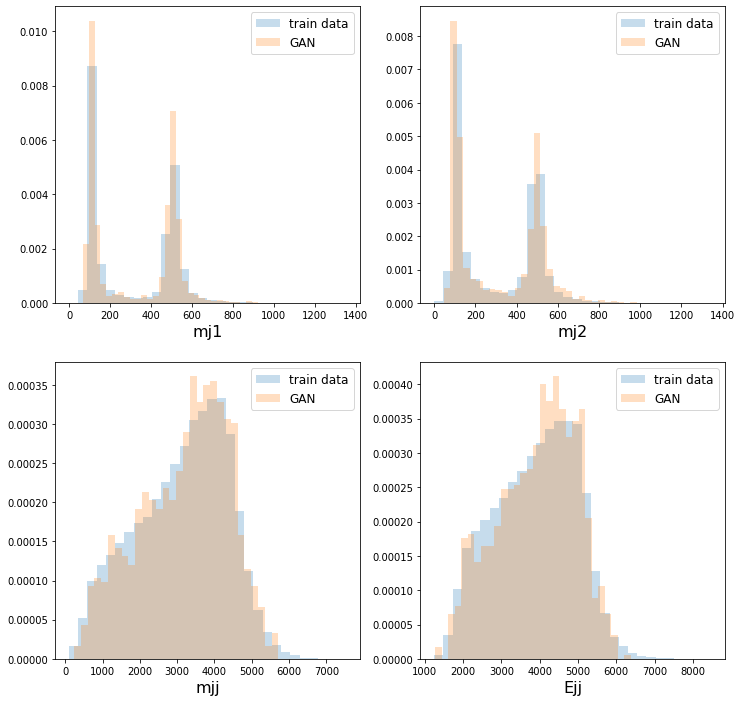

In [15]:
generator = load_model(path + 'generator.h5')

NOISE_DIM = 128
BATCH_SIZE = 1000
gen_input = tf.random.uniform([BATCH_SIZE, NOISE_DIM])
generated_vector = generator(gen_input, training=False)
generated_vector = np.array(generated_vector)
generated_vector = scaler.inverse_transform(generated_vector)

df = pd.DataFrame()
for ifs,feature in enumerate(train_features):
    df[feature] = generated_vector[:,ifs]
    
# x_train_inv_scaled = scaler.inverse_transform(x_train)

pxj1 = df['pxj1']; pxj2 = df['pxj2']
pyj1 = df['pyj1']; pyj2 = df['pxj2']
pzj1 = df['pzj1']; pzj2 = df['pxj2']
mj1  = df['mj1'] ; mj2  = df['pxj2']

# let c=1, E^2 = m^2*c^4 + p^2*c^2 = m^2 + p^2
Ej1 = np.sqrt(mj1**2 + pxj1**2 + pyj1**2 + pzj1**2)
Ej2 = np.sqrt(mj2**2 + pxj2**2 + pyj2**2 + pzj2**2)

Ejj = Ej1 + Ej2
mjj = np.sqrt(Ejj**2 - ((pxj1+pxj2)**2 + (pyj1+pyj2)**2 + (pzj1+pzj2)**2))
df['mjj'] = mjj
df['Ejj'] = Ejj

names = ['mj1', 'mj2', 'mjj', 'Ejj']
plt.figure(figsize=(12,12))
for iname, name in enumerate(names):
    plt.subplot(2,2,iname+1)
    x_train = train_data[name]
    x = df[name]
    plt.hist(x_train, density=True, bins=30, alpha=0.25, label='train data')
    plt.hist(x, density=True, bins=30, alpha=0.25, label='GAN')
    plt.xlabel(name, fontsize=16)
    plt.legend(fontsize=12)
plt.show()